In [1]:
#ex week 10!
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

IMAGE STITCHING,
sift and descriptors using cross checking
ransac algotrithm

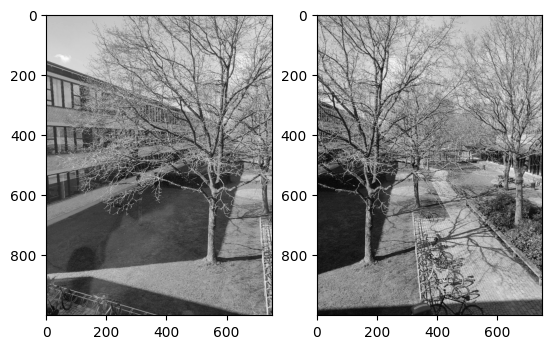

In [3]:
# Load images
left_color = cv2.imread('week10_data/im2.jpg')
left = cv2.cvtColor(left_color, cv2.COLOR_RGB2GRAY)
right_color = cv2.imread('week10_data/im1.jpg')
right = cv2.cvtColor(right_color, cv2.COLOR_RGB2GRAY)

# Show
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(left, cmap="gray")
ax[1].imshow(right, cmap="gray");

In [6]:
'''Find SIFT keypoints (kp1, kp2) in both images and 
compute their descriptors (des1, des2).'''

# 1 SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left, None)
kp2, des2 = sift.detectAndCompute(right, None)

'''Match the SIFT features from both images to each other. Use Cross Checking'''
# part 2: 2-KNN match with two (best and second best)
bf = cv2.BFMatcher()
knn_matches = bf.knnMatch(des1, des2, k=2)
all_matches = bf.match(des1, des2)

## Go from tuple -> array
kp1 = np.asarray(kp1)
kp2 = np.asarray(kp2)
#ratio test :
kp1_indexes = []
kp2_indexes = []
ratio_matches = []
for m,n in knn_matches:
    if m.distance < 0.90*n.distance:
        ratio_matches.append([m])
        kp1_indexes.append(m.queryIdx)
        kp2_indexes.append(m.trainIdx)


## 4 extract the keypoints of the "good" matches
match_points1_ratio = [p.pt for p in kp1[kp1_indexes]]
match_points2_ratio = [p.pt for p in kp2[kp2_indexes]]

p1_ratio = np.array(match_points1_ratio).astype(np.float32)
p2_ratio = np.array(match_points2_ratio).astype(np.float32)

p1s_ratio = np.vstack((p1_ratio.T, np.ones(p1_ratio.shape[0])))
p2s_ratio = np.vstack((p2_ratio.T, np.ones(p2_ratio.shape[0])))

## OR! use all matches!

p1 = np.float32([kp1[m.queryIdx].pt for m in all_matches])
p2 = np.float32([kp2[m.trainIdx].pt for m in all_matches])

p1s = np.vstack((p1.T, np.ones(p1.shape[0])))
p2s = np.vstack((p2.T, np.ones(p2.shape[0])))


In [7]:
# To test the built in function
src_pts = np.float32([kp1[m.queryIdx].pt for m in all_matches]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in all_matches]).reshape(-1,1,2)


print("ALL:", p1s.shape, p2s.shape)
print("Ratio:", p1s_ratio.shape, p2s_ratio.shape)

ALL: (3, 6200) (3, 6200)
Ratio: (3, 1395) (3, 1395)


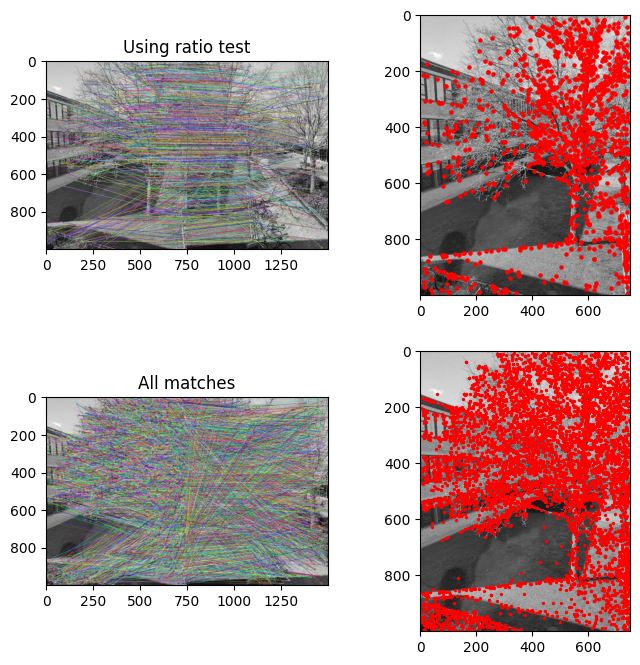

In [8]:
match_image_ratio = cv2.drawMatchesKnn(left,kp1,right,kp2, ratio_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
match_image_all = cv2.drawMatches(left,kp1,right,kp2, all_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs[0, 0].set_title("Using ratio test")
axs[0, 0].imshow(match_image_ratio)
axs[0, 1].scatter(p1_ratio[:, 0], p1_ratio[:, 1], s=5, c="red")
axs[1, 0].set_title("All matches")
axs[0, 1].imshow(left, cmap="gray")
axs[1, 0].imshow(match_image_all)
axs[1, 1].scatter(p1[:, 0], p1[:, 1], s=2, c="red")
axs[1, 1].imshow(left, cmap="gray")

In [ ]:

plt.imshow(match_image_ratio)
plt.title("Ratio matches");

10.2 Implement RANSAC for finding homographies between the images.

What is the minimum number of matches you need to estimate a homography?

Ans: H matrix is 3x3, with 9 DoF. But as H is scale invariant (as its multiplying homogenous points) it only has 8 DoF
Each pair of points imposes 2 constraints (x,y), meaning that four points gives 8 constraints.
In conclusion, we need four pairs of points.


Use Equation (2.45) from the lecture notes to compute the distance of a match to a homography.
Assume σ = 3 and use the formulas from the lecture last week to determine the threshold for when
a match should be considered an inlier.

While best practice would be to determine the number of iterations while running the algorithm,
you can fix it to i.e. 200.

To verify that the inliers of the best model are reasonable, visualize them.
Consider using the following code: plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[bestInliers], None))\

NB On the provided images you should find in the ballpark of a thousand inliers

In [11]:
#from week 4
def hest(q1,q2):
    """
    Estimates H given points Q1, Q2 on the two image planes. 
    Need at least 4 pairs of points to estimate the matrix with 8 degrees of freedom.
    """
    q1,T1 = normalize2d(q1)
    q2,T2 = normalize2d(q2)
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b(q1,q2) #np.vstack((B0,B1))
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    return (np.linalg.inv(T1)@H.T@T2.round(2))

def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

def crossop(p):
    return np.array([[0,-p[2],p[1]],
                    [p[2],0,-p[0]],
                    [-p[1],p[0],0]])

def get_b(q1,q2):
    B = np.kron(q2[:,0], crossop(q1[:,0]))
    for i in range(1,len(q1.T)):
        B_temp = np.kron(q2[:,i], crossop(q1[:,i]))
        B = np.vstack((B,B_temp))
    return B

def PI(q):
    return q[:2]/q[2]

In [12]:
#ransac implementation
def approx_dist(Hest, p1, p2):
    """
    Absolute squared distance between the 
    reprojections from one image plane to the other.
    """
    # Non-homogenous to get actual distances.
    q1 = PI(p1)
    q2 = PI(p2)

    # Approximate distance, using matched points.
    left_dist = q1 - PI(Hest@p2)

    try:
        right_dist = q2 - PI(np.linalg.inv(Hest)@p1)
    except np.linalg.LinAlgError:
        right_dist = q2 - PI(np.linalg.pinv(Hest)@p1)

    return np.linalg.norm(left_dist, axis=0, ord=2)**2 + np.linalg.norm(right_dist, axis=0, ord=2)**2


def consensus(Hest, q1, q2, sigma):
    '''
    Counts no. inliers given an estimated H. 
    Also returns the index of the inliers.
    '''
    # Threshold given the KJI-square distribution again,
    # as the distance we calculate is squared.
    threshold = 3.84*sigma**2
    inliers_index = []
    inliers_index = np.where(approx_dist(Hest, q1, q2)<threshold)[0]
    return len(inliers_index), np.asarray(inliers_index)

def RANSAC_hest(p1s, p2s, sigma=3, iterations=5000):
    # RANSAC iterations
    best_inlier_count = 0
    best_inlier_idx = None
    H_best=None
    #Loop
    for i in tqdm(range(iterations)):
        # Draw eight random matches
        match_idx = np.random.randint(low=0, high=len(p1s[0]), size=(8,))
        p1_sample = p1s[:, match_idx]
        p2_sample = p2s[:, match_idx]
        # Estimate the homography
        H_est = hest(p1_sample,p2_sample)
        # Find no. inliers
        no_inliers, inlier_index = consensus(H_est, p1s, p2s, sigma)
        if no_inliers>best_inlier_count:
            best_inlier_count = no_inliers
            best_inlier_idx = inlier_index
            H_best = H_est
            #print(i, "New best estimate!")

    # Now, use all inliers of best F to match a final F
    print("Inliers count:", best_inlier_count)
    H_final = hest(p1s[:, best_inlier_idx], p2s[:, best_inlier_idx])
    if H_final[1, 1]==0:
        print("Bad final match")
        return H_best, best_inlier_idx
    return H_final, best_inlier_idx

In [13]:
Hest, inlier_index = RANSAC_hest(p1s_ratio, p2s_ratio, sigma=30, iterations=20000)


100%|██████████| 20000/20000 [00:04<00:00, 4265.22it/s]

Inliers count: 889
Bad final match


Text(0.5, 1.0, 'Constrained matches')

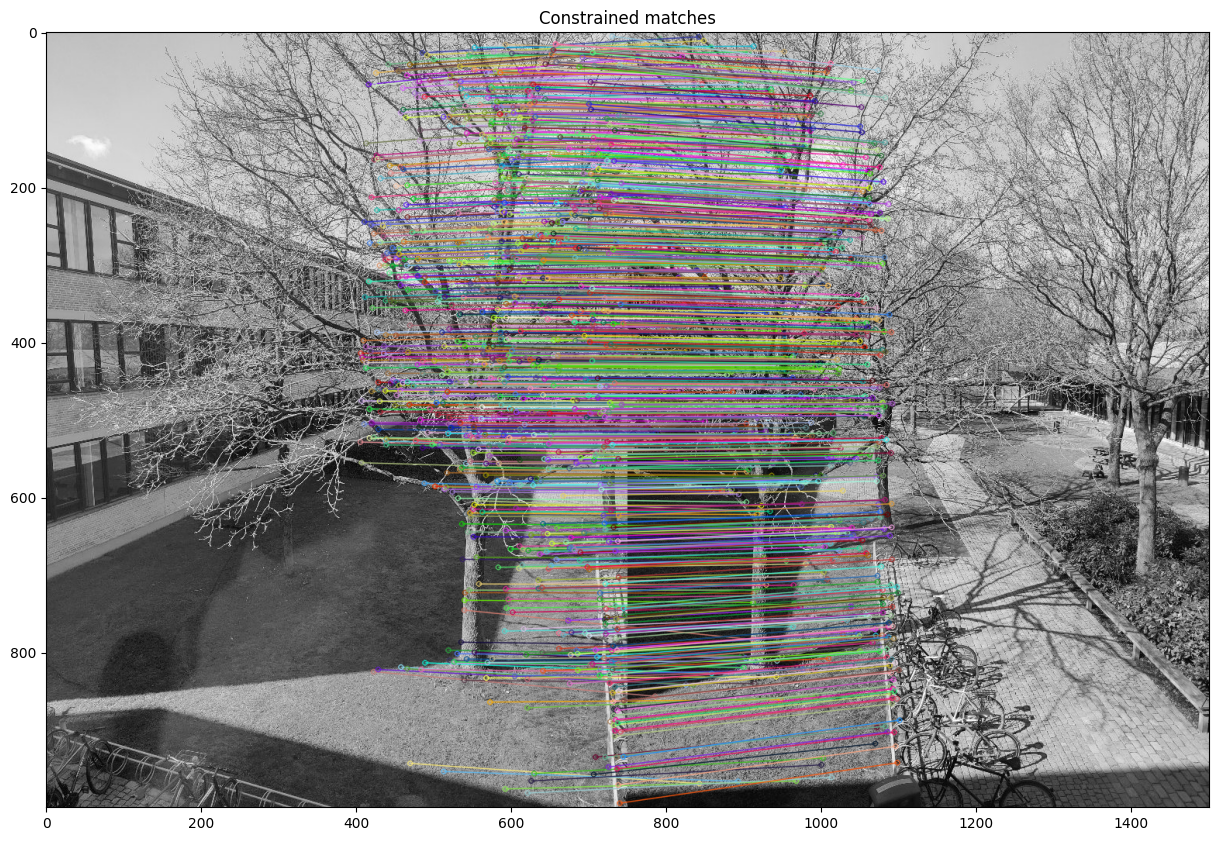

In [15]:
plt.figure(figsize=(15, 15))
plt.imshow(cv2.drawMatchesKnn(left,kp1,right,kp2, np.array(ratio_matches)[inlier_index], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
plt.title("Constrained matches")
#plt.imshow(cv2.drawMatches(left,kp1,right,kp2, np.array(all_matches)[inlier_index], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS));

part 10.3

Wrap your code from the previous exercise in a function: H = estHomographyRANSAC(kp1, des1, kp2, des2).

The function should take SIFT keypoints and descriptors computed on two images and use RANSAC to estimate the best homography between the images.
Make sure that the function ends with fitting a homography to the largest amount of inliers.

In [18]:
def estHomographyRANSAC(kp1, des1, kp2, des2):
    # Match the SIFT features from both images to each other
    bf = cv2.BFMatcher()
    knn_matches = bf.knnMatch(des1, des2, k=2)

    # Ratio test
    kp1_indexes = []
    kp2_indexes = []
    ratio_matches = []
    for m, n in knn_matches:
        if m.distance < 0.90 * n.distance:
            ratio_matches.append([m])
            kp1_indexes.append(m.queryIdx)
            kp2_indexes.append(m.trainIdx)

    # Extract the keypoints of the "good" matches
    match_points1_ratio = [p.pt for p in kp1[kp1_indexes]]
    match_points2_ratio = [p.pt for p in kp2[kp2_indexes]]

    p1_ratio = np.array(match_points1_ratio).astype(np.float32)
    p2_ratio = np.array(match_points2_ratio).astype(np.float32)

    p1s_ratio = np.vstack((p1_ratio.T, np.ones(p1_ratio.shape[0])))
    p2s_ratio = np.vstack((p2_ratio.T, np.ones(p2_ratio.shape[0])))

    # RANSAC to estimate the best homography
    Hest, inlier_index = RANSAC_hest(p1s_ratio, p2s_ratio, sigma=30, iterations=20000)

    return Hest, inlier_index

part 10.4

'warpImage' takes an image and a homography and returns the image warped with the homography, where xRange and yRange specifies for which range of x and y values the image should be sampled. The function returns the transformed version of the image, and a mask that is 1 where the image is valid.

Start out by setting

xRange = [0, im1.shape[1]]
yRange = [0, im1.shape[0]]

Warp one of your images using the estimated homography. Which image you should warp, depends on if you have found the homography going from image one to two or vice versa. This should warp this image to the other, thus cutting off a lot of the content of that image.

Use the warping function on the other image but set the homography to the identity. Change xRange and yRange so the images are no longer getting cropped by the warp.

In [17]:
#warping function
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    mask = np.ones(im.shape[:2], dtype=np.uint8)*255
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(mask, H, outSize)
    return imWarp, maskWarp


In [19]:
H, inlier_index = RANSAC_hest(p1s_ratio, p2s_ratio, sigma=30, iterations=20000)
overlap_points = p2[inlier_index]
H

100%|██████████| 20000/20000 [00:04<00:00, 4263.92it/s]

Inliers count: 888
Bad final match


array([[ 4.13372509e-01, -4.01602259e-03,  2.60646273e+02],
       [-1.62339356e-01,  6.03434309e-01,  2.33925516e+01],
       [-3.43766605e-04,  2.65474643e-05,  6.36213426e-01]])

In [20]:
H2, inlier_index2 = estHomographyRANSAC(kp1, des1, kp2, des2)
H2

100%|██████████| 20000/20000 [00:04<00:00, 4401.52it/s]

Inliers count: 653


array([[ 3.30037079e-01, -1.31380220e-02,  2.58510424e+02],
       [-1.41333932e-01,  9.19559148e-01,  2.74903052e+01],
       [-3.01633372e-04,  9.46695266e-06,  6.36043320e-01]])

Useful pixel left 136.60714285714286
Useful pixel right 181.0845192857143


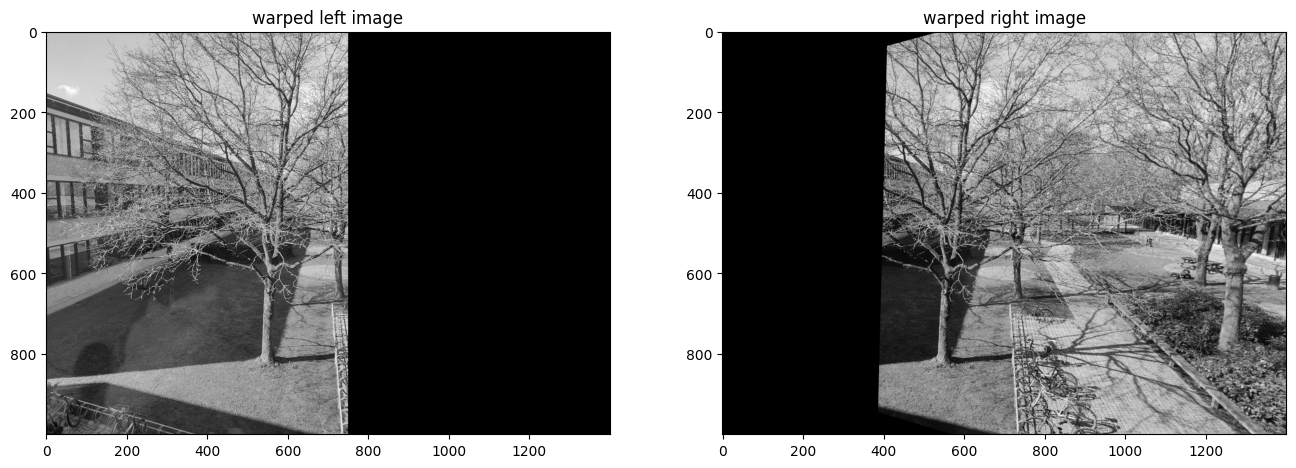

In [21]:
#with H 
xRange = [0, 1400]
yRange = [0, left.shape[0]]

left_warp, left_mask = warpImage(left, np.identity(3), xRange, yRange)
print("Useful pixel left", np.mean(left_mask))

right_warp, right_mask = warpImage(right, H, xRange, yRange)
print("Useful pixel right", np.mean(right_mask))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,12))
axs[0].imshow(left_warp, cmap="gray")
axs[0].set_title("warped left image")
axs[1].imshow(right_warp, cmap="gray")
axs[1].set_title("warped right image");

part 10.5

Use the mask returned by the warping function, to generate a single image that contains bothimages. Where the images overlap you can use the intensities from either image.

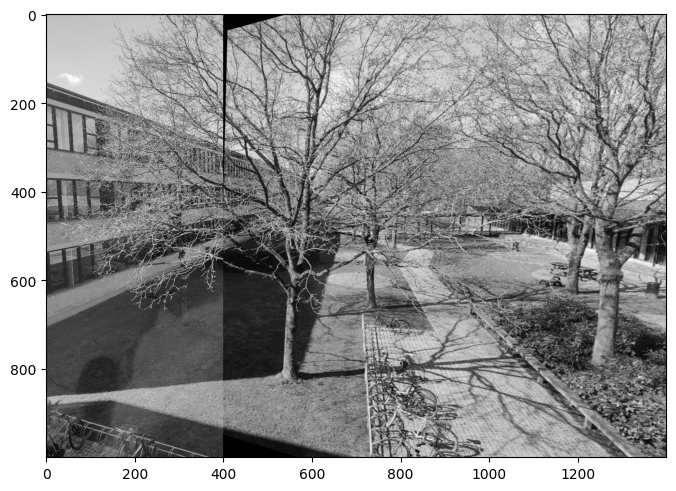

In [22]:
# Since the right image is the base image, we use the left image as canvas, and draw the right image on top.
canvas = right_warp.copy()
#canvas[:, 0:left.shape[1]] = left_warp[:, 0:left.shape[1]]
canvas[:, 0:400] = left_warp[:, 0:400]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axs.imshow(canvas, cmap="gray")

In [23]:
#using built in functions
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist() # List of what matches were used in final.
len(src_pts), len(matchesMask)

(6200, 6200)

In [24]:
M*1/M[0,0], H*1/H[0,0]

(array([[ 1.00000000e+00,  1.79973962e-02, -4.07008298e+02],
        [ 2.54825047e-01,  9.09212311e-01, -1.42447120e+02],
        [ 5.42913607e-04,  3.50820079e-06,  6.03164545e-01]]),
 array([[ 1.00000000e+00, -9.71526288e-03,  6.30536060e+02],
        [-3.92719285e-01,  1.45978336e+00,  5.65895194e+01],
        [-8.31614580e-04,  6.42216494e-05,  1.53908016e+00]]))

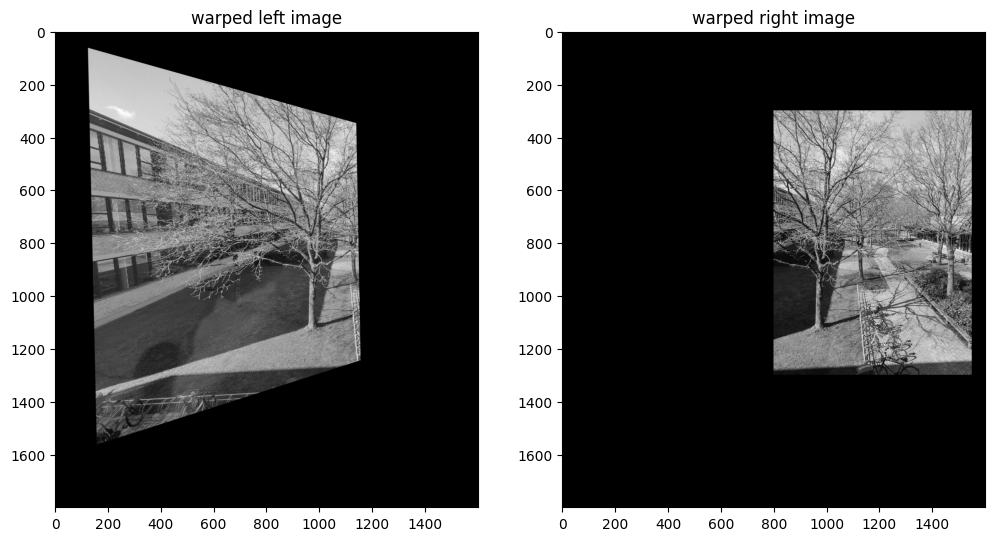

In [25]:
#xRange = [0, left.shape[1]]
#yRange = [0, left.shape[0]]

xRange = [-800, 800]
yRange = [-300, 1500]

left_warp, left_mask = warpImage(left, M, xRange, yRange)

right_warp, right_mask = warpImage(right, np.identity(3), xRange, yRange)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].imshow(left_warp, cmap="gray")
axs[0].set_title("warped left image")
axs[1].imshow(right_warp, cmap="gray")
axs[1].set_title("warped right image");

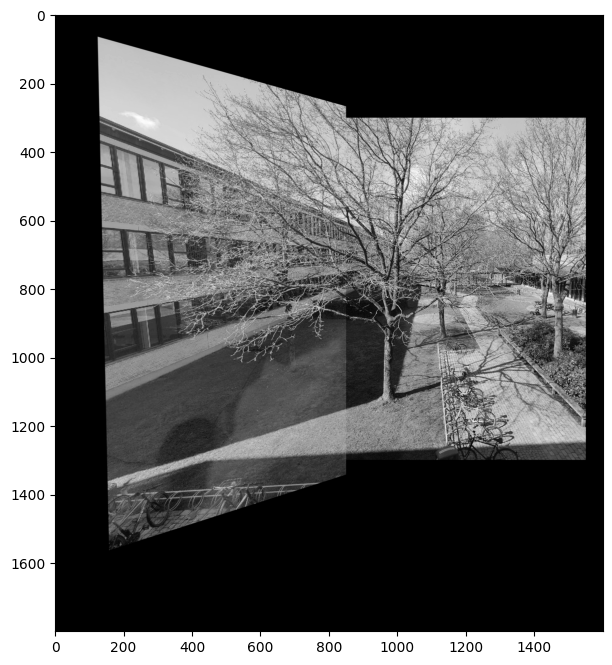

In [26]:

# Since the right image is the base image, we use the left image as canvas, and draw the right image on top.
canvas = left_warp.copy()
canvas[:, -right.shape[1]:] = right_warp[:, -right.shape[1]:]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axs.imshow(canvas, cmap="gray")